In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [173]:
df = pd.read_parquet('data/95-25.parquet')

# fft на всем ряде

In [152]:
import numpy as np
from scipy.fft import rfft, irfft

def get_trend_seasonal(ts, top_n=12):
    fft = rfft(ts)
    amps = np.abs(fft)
    top_idx = np.argsort(amps)[-top_n:]
    filtered = np.zeros_like(fft)
    filtered[top_idx] = fft[top_idx]
    trend_seasonal = irfft(filtered, n=ts.shape[0])
    return trend_seasonal, fft, top_idx

trend_seas, fft_all, top_idx = get_trend_seasonal(df['Bx'].values)


In [153]:
trend_seas_diff, _, _ = get_trend_seasonal(df['Bx'].diff().fillna(0).values)

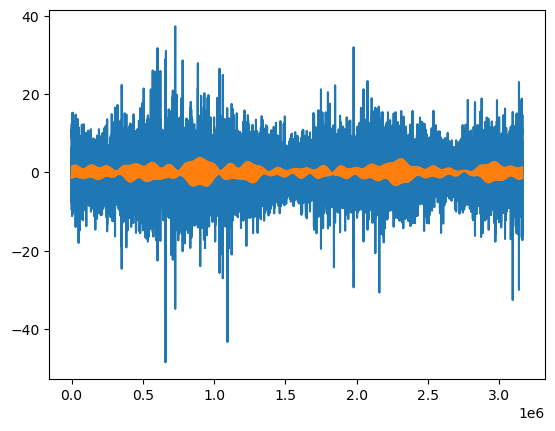

In [154]:

plt.plot(df['Bx'].values)
plt.plot(trend_seas)

# 100к окно скользящее fft

In [155]:
from tqdm import trange

def rolling_fourier_detrend(data, window_size=10000, n_harm=12, stride=1):
    n = len(data)
    trend = np.zeros(n)
    window = np.hanning(window_size)
    for end in trange(window_size, n, stride):
        start = end - window_size
        chunk = data[start:end] * window
        fft = rfft(chunk)
        amps = np.abs(fft)
        top_idx = np.argsort(amps)[-n_harm:]
        fft_filtered = np.zeros_like(fft)
        fft_filtered[top_idx] = fft[top_idx]
        chunk_trend = irfft(fft_filtered, n=window_size)
        trend[end-1] = chunk_trend[-1]
        # при stride > 1: линейно интерполировать промежуточные точки!
    return trend


In [156]:
trend = rolling_fourier_detrend(df['Bx'].iloc[:200_000].values, window_size=100_000, n_harm=12)

  1%|▏         | 1469/100000 [00:06<07:23, 222.35it/s]


KeyboardInterrupt: 

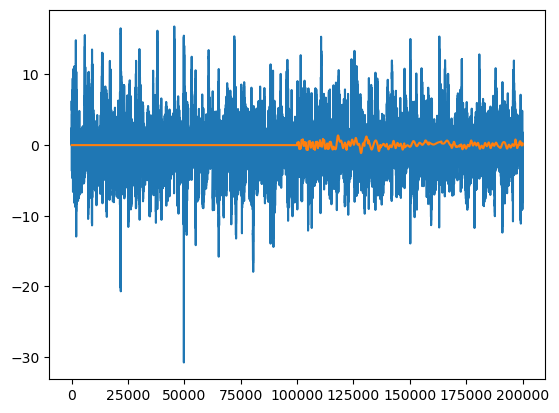

In [37]:

plt.plot(df['Bx'].iloc[:200_000].values)
plt.plot(trend)

# fft на отложенной выборке и продолжение гармоник на весь ряд

In [157]:
import numpy as np
from scipy.fft import rfft

def make_fourier_predictor(x_first, total_len, top_n=12):
    n = len(x_first)
    fft = rfft(x_first)
    amps = np.abs(fft)
    phases = np.angle(fft)
    top_idx = np.argsort(amps)[-top_n:]
    freqs = np.fft.rfftfreq(n)
    # Экстраполирующая функция
    def extrapolator(t):
        pred = 0
        for i in top_idx:
            pred += 2 * amps[i] / n * np.cos(2 * np.pi * freqs[i] * t + phases[i])
        return pred
    # Векторизуем на всю выборку
    t_all = np.arange(total_len)
    extrapolated = np.array([extrapolator(t) for t in t_all])
    return extrapolated


In [167]:
fourier_predictor = make_fourier_predictor(df['Bx'].iloc[:].values, len(df), 50)

[]

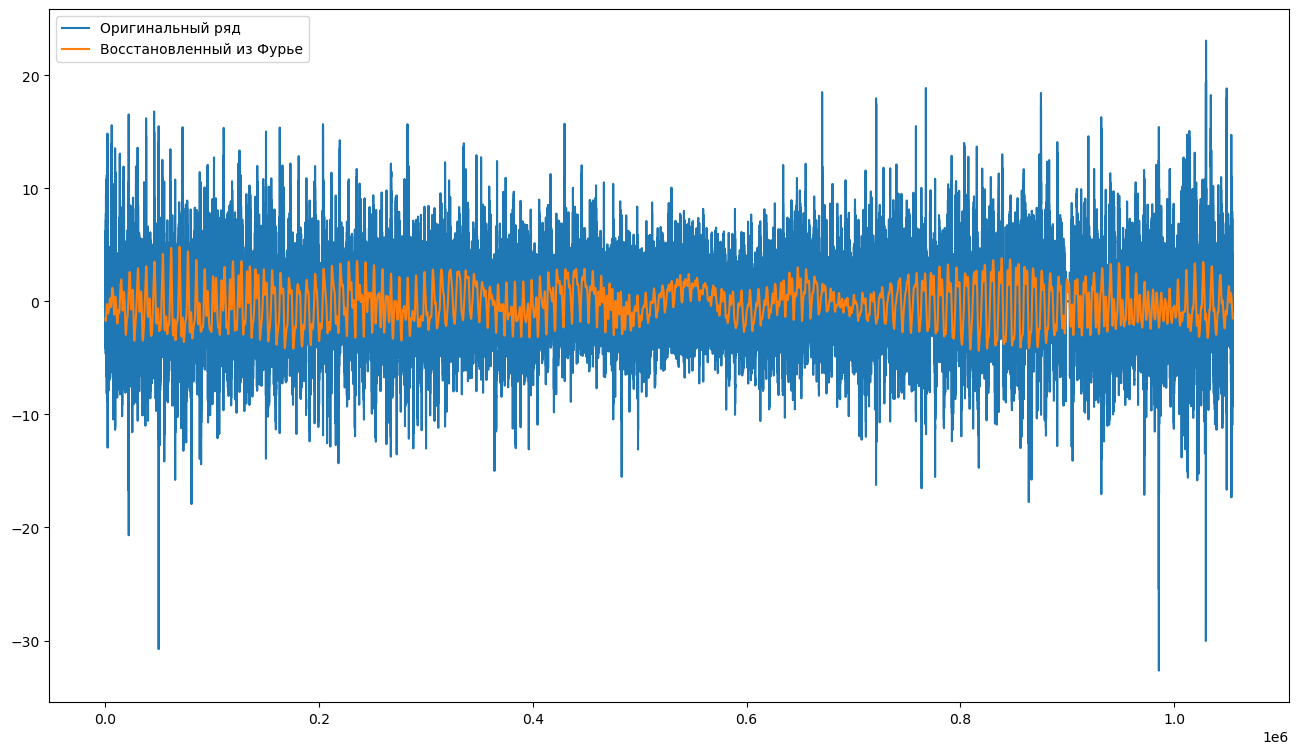

In [168]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(df['Bx'].values, label='Оригинальный ряд')
ax.plot(fourier_predictor, label='Восстановленный из Фурье')
plt.legend()
plt.plot()

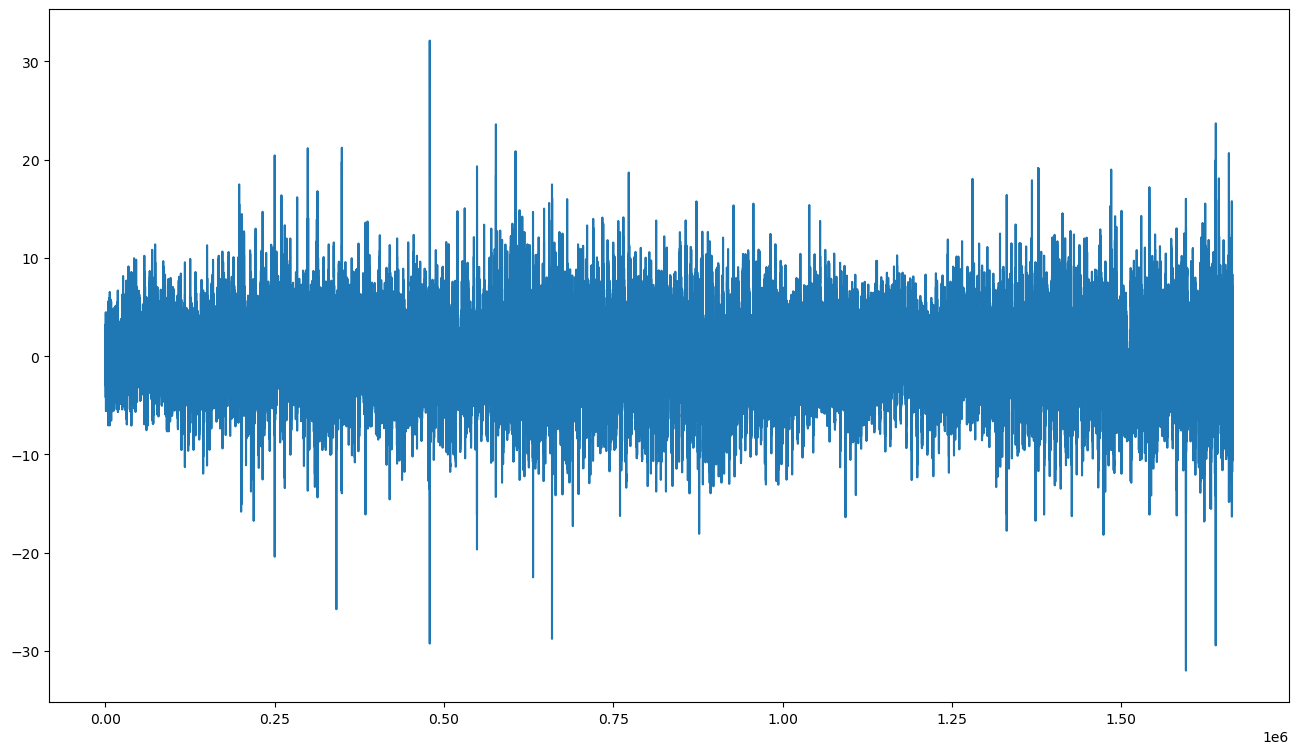

In [109]:
# остатки
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot((df['Bx'] - fourier_predictor).iloc[1_500_000:].values)

In [116]:
df = df.reset_index(drop=True)

In [119]:
df['fourier_predictor'] = fourier_predictor

In [122]:
df.iloc[1_500_000:].to_parquet('data/bx_fourier_clean.parquet')

# то же самое только данные аггрегированы за день

In [175]:
df_date = df.groupby(df['datetime'].dt.date)[['Bx']].mean()

In [176]:
fourier_predictor = make_fourier_predictor(df_date['Bx'].iloc[:5000].values, len(df_date))

[]

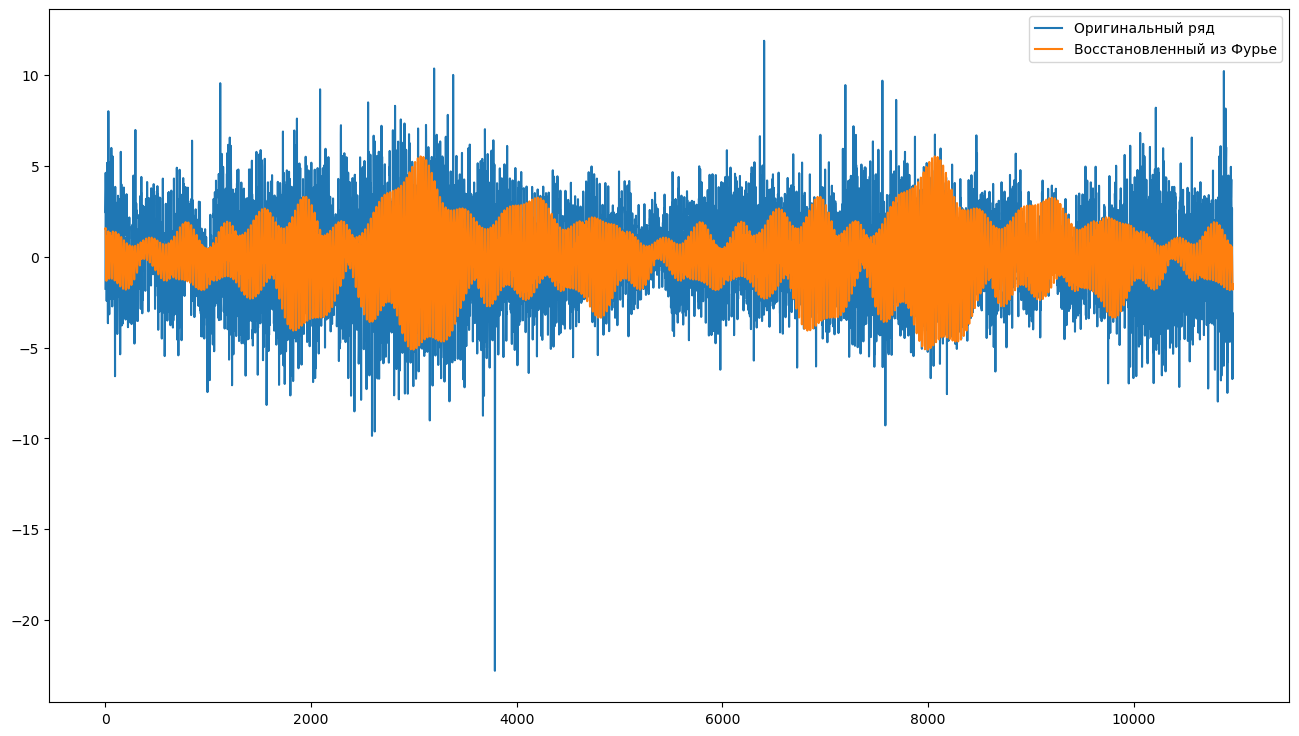

In [177]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(df_date['Bx'].values, label='Оригинальный ряд')
ax.plot(fourier_predictor, label='Восстановленный из Фурье')
plt.legend()
plt.plot()

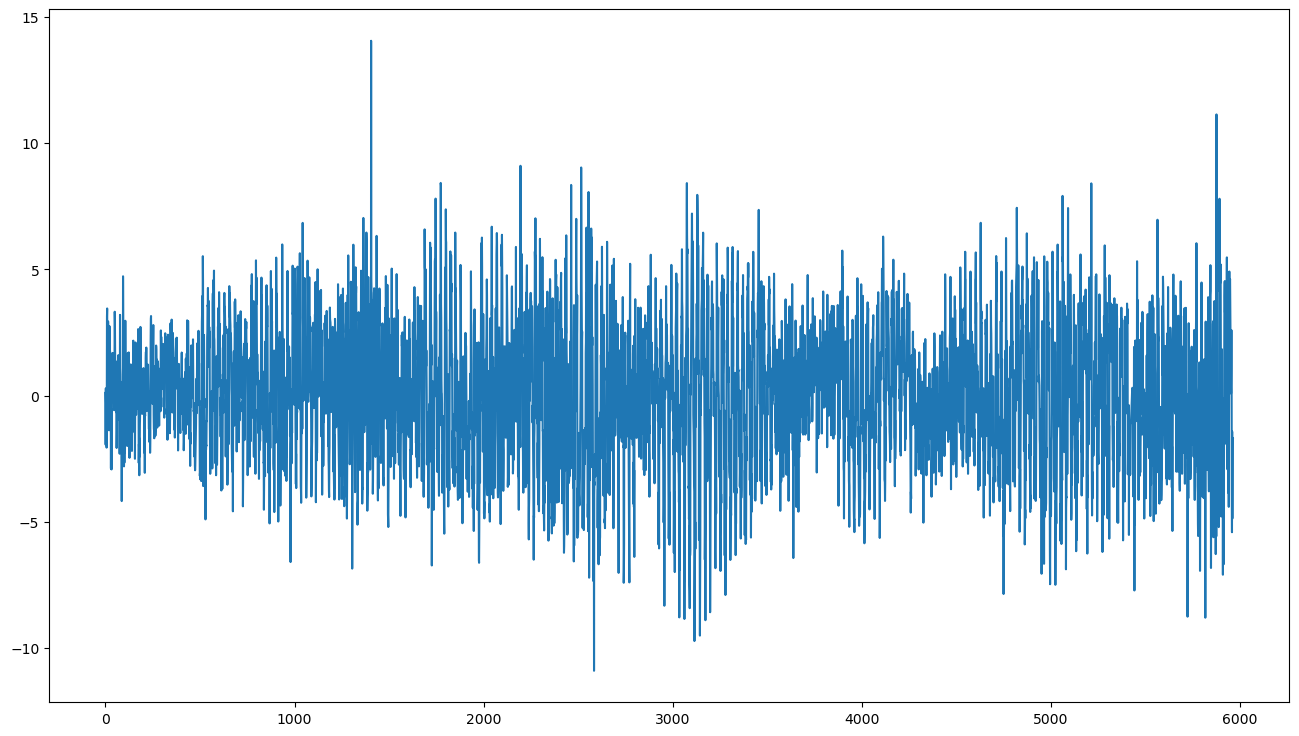

In [ ]:
# остатки
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((df_date['Bx'] - fourier_predictor).iloc[5000:].values)

# скользящее окно фурье только для аггрегатов по дате

In [98]:
trend = rolling_fourier_detrend(df_date['Bx'].values, window_size=1200, n_harm=12)

100%|██████████| 9763/9763 [00:00<00:00, 20717.90it/s]


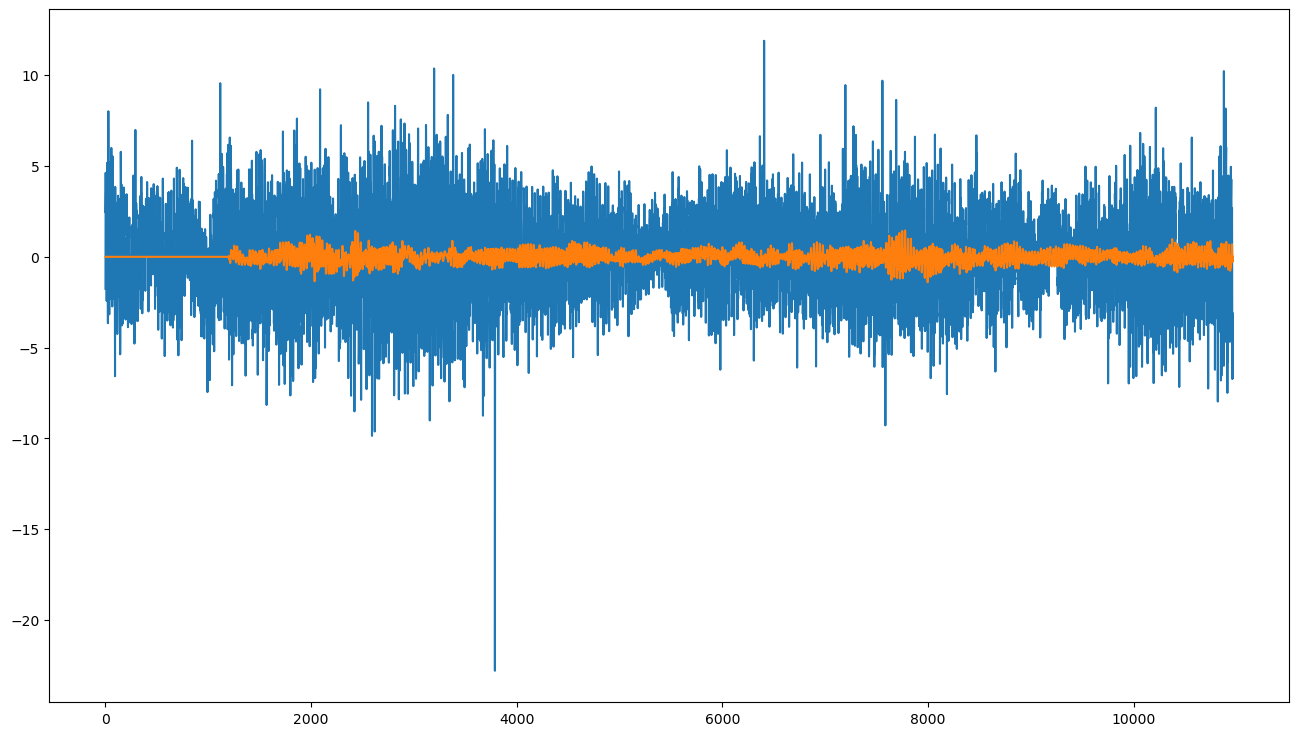

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(df_date['Bx'].values)
ax.plot(trend)

In [126]:
df_date.query('Bx == 0')

,Bx
datetime,
1995-11-28,0.0
1995-12-21,0.0
1996-10-04,0.0
1996-12-31,0.0
1997-09-08,0.0
1999-11-17,0.0
2000-07-15,0.0
2000-08-17,0.0
2000-08-18,0.0


In [144]:
df_date.loc[pd.to_datetime('2014-11-25').date()]

Bx    0.0
Name: 2014-11-25, dtype: float64

In [134]:
df_date.index[0]

datetime.date(1995, 1, 1)

In [137]:
pd.datetime.date(1995, 1, 1)

AttributeError: module 'pandas' has no attribute 'datetime'

In [ ]:
pd.to_datetime('2014-11-25').date()

datetime.date(2014, 11, 25)